In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import category_encoders as ce

In [2]:
df_input = pd.read_csv('./data/train.csv')
temp = df_input.pop('Id')
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(df_input)
# x_train = df_encoded.sample(frac=0.8,random_state=0)
# x_test = df_encoded.drop(x_train.index)
# y_train = x_train.pop('SalePrice')
# y_test = x_test.pop('SalePrice')
x_train = df_encoded
y_train = x_train.pop('SalePrice')

train_stats = x_train.describe()
train_stats = train_stats.transpose()

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_x_train = norm(x_train)
# normed_x_test = norm(x_test)

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________


In [3]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)



history = model.fit(
  normed_x_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................

In [4]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
460,1.288955e+09,23481.757812,1.288956e+09,1.019619e+09,20120.912109,1.019619e+09,460
461,1.277923e+09,23575.693359,1.277923e+09,1.020476e+09,20022.781250,1.020476e+09,461
462,1.277209e+09,23609.636719,1.277209e+09,1.019024e+09,19972.398438,1.019023e+09,462
463,1.275874e+09,23487.107422,1.275874e+09,1.019033e+09,20025.966797,1.019033e+09,463
464,1.277322e+09,23446.777344,1.277321e+09,1.018841e+09,20050.966797,1.018841e+09,464


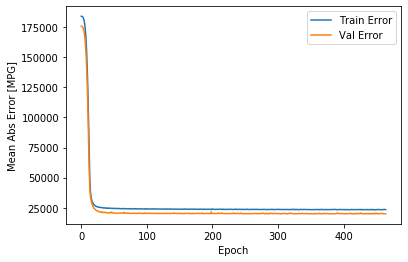

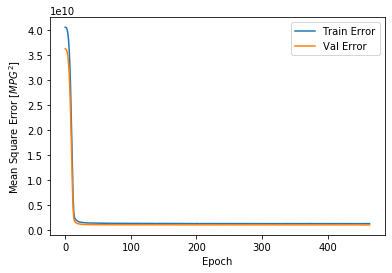

In [5]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    # plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  # plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

In [7]:
# newdata = df_encoded
# new_label = newdata.pop('SalePrice')
newdata = x_train
new_label = y_train
normed_train = norm(newdata)

In [8]:
from decimal import Decimal
new_predict = model.predict(normed_train)
new_predict = new_predict.astype(int)
df = pd.DataFrame({'Actual': new_label, 'Predicted': new_predict.flatten()})
test_mse = ((df.Actual - df.Predicted) ** 2).mean()
print("{:.4E}".format(Decimal(test_mse)))

1.2088E+9


In [9]:
(((df.Actual - df.Predicted) ** 2) / (df.Actual ** 2)).mean()

0.04774698465892753

64-64-64-64-64-1  
1.2378E+9  
  
64-64-64-64-1  
earlystop:1.2088E+9  
nonstop:1.2955E+9  
  
64-64-64-1  
1.2428E+9  
64-64-1  
1.2802E+9  
64-1  
2.4108E+10

In [11]:
test_input = pd.read_csv('./data/test.csv')
id_col = test_input.pop('Id')
encode_input = encoder.fit_transform(test_input)
normed_test_input = norm(encode_input)
test_predict = model.predict(normed_test_input)
test_predict = test_predict.astype(int)
df_test_result = pd.DataFrame({'Id': id_col, 'SalePrice': test_predict.flatten()})
df_test_result

,Id,SalePrice
0,1202,209990
1,1203,125136
2,1204,186805
3,1205,135508
4,1206,273966
...,...,...
254,1456,175656
255,1457,207188
256,1458,201413
257,1459,115709


In [12]:
df_test_result.to_csv(r'./data/submission.csv', index=None)